# Toy MC for the ATLAS High Granularity Timing Detector

In [1]:
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import time 

Welcome to JupyROOT 6.22/08


### Constants

In [2]:
nr_of_channels = int(3.6 * 1e6)
channels_per_module = int(15*30)
total_modules = int(nr_of_channels/channels_per_module)
global_counter = 0

### Noise Generator Class:
This class takes in the parameters threshold and channel count (proportional to the number of interactions mu per bunch crossing) and calculates the mean number of channels activated by noise by calculating the probability mass that a part of the Gaussian distribution will be above the set average, and multiplies it with the total number of channels. The class has a function generate, which calculates a variation of the mean number of noise activated channels by drawing from a Poisson dist. with mean as parameter, and calculates how many of them are triggered during the small time window of 3.125ns (true value of them!) by drawing from a uniform dist. (0,1) for each number of noise activated channel and seeing how many are under 0.125 (3.125/25 = 0.125). Finally, it estimates the number of triggered channels in the small window by determining the number of channels triggered in one ns and multiplying by 3.125ns. This way, we have a true number of noise activated channels in the small window, and one that is estimated.

try different big time windows , eg 4*3.125, lines 25-26. Change value of *big_window*

In [52]:
class noise_generator:
    def __init__(self, threshold, channel_count): 
        global global_counter
        low = 0
        high = 1000
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        """Why divide with 2?? Why do we need a avg. value?"""
        #integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg.
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)

    def generate(self):
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        # Large time window 25ns
        # Small time window 3.125ns
        prng = self._prng
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        
        narrow_exact = 0
        big_window = 3*3.125
        
        #narrow_exact = (np.random.rand(total) < 0.125).sum()  # 3.125/25 = 0.125
        #noise_per_time = (total - narrow_exact)/(25 - 3.125)
        
        narrow_exact = (np.random.rand(total) < 3.125/big_window).sum() # ex. 3.125/(3.125*4) big window of 4 times 3.125 
        noise_per_time = (total - narrow_exact)/(big_window - 3.125)
        
        estimate = 3.125 * noise_per_time
        return narrow_exact, estimate




 ### Signal Generator Class:
 This class takes the input parametes threshold and the real and guessed most probable peak voltage of the signal distribution (100mV when the sensors are new). It calculates the fraction of the Landau distribution that will be above the set threshold. It has a function generate, which takes in the paramter expected_count, that is, the estimated number of particles that will reach the detector (for mu=200 it is around 15k), then it determines a possible number of hits on the detector by drawing from a Poisson distribution around that parameter. Finally, for each calculated hit, it determines how many channels were triggered by signal from a particle by sampling a Landau distribution and checking how many of them are above the threshold. It returns the number of particles hitting the detector, and the number of signal-activated channels.

In [4]:
class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) #fraction of the function that is above threshold
        #self._prng = ROOT.TRandom3(time.time_ns())
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    

## Simulation function


In [15]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above

    for BC in range(bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        #print("True number of signal-activated channels: %d" %result_true_signal_count[BC])
        #print("Estimated number of signal-activated channels: %f" % result_estimated_signal_count[BC])
        error_estimation = 0
        
    return result_true_signal_count, result_estimated_signal_count



In [28]:
"""Parameters for the simulation"""
peak_mpv_voltage = 100 #mV, mpv: most probable value
guess_mpv_voltage = 100 #mV
mu = 200
"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
bunch_crossings = 50
ratio_of_channels_to_sample = 0.5
print("Expected count: %f" %expected_count)

Expected count: 15000.000000


 ### Graphical estimation of best threshold with regards to deviation from the true signal

Deviation for threshold 0.000000: 0.005450
Deviation for threshold 3.333333: 0.005564
Deviation for threshold 6.666667: 0.002645
Deviation for threshold 10.000000: 0.000897
Deviation for threshold 13.333333: 0.000314
Deviation for threshold 16.666667: 0.000245
Deviation for threshold 20.000000: 0.000013
Deviation for threshold 23.333333: 0.000009
Deviation for threshold 26.666667: 0.000006
Deviation for threshold 30.000000: 0.000001
Deviation for threshold 33.333333: 0.000023
Deviation for threshold 36.666667: 0.000077
Deviation for threshold 40.000000: 0.000167
Deviation for threshold 43.333333: 0.000244
Deviation for threshold 46.666667: 0.000194
Deviation for threshold 50.000000: 0.000485
Deviation for threshold 53.333333: 0.000869
Deviation for threshold 56.666667: 0.000955
Deviation for threshold 60.000000: 0.001351
Deviation for threshold 63.333333: 0.001706
Deviation for threshold 66.666667: 0.002163
Deviation for threshold 70.000000: 0.003523
Deviation for threshold 73.333333: 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


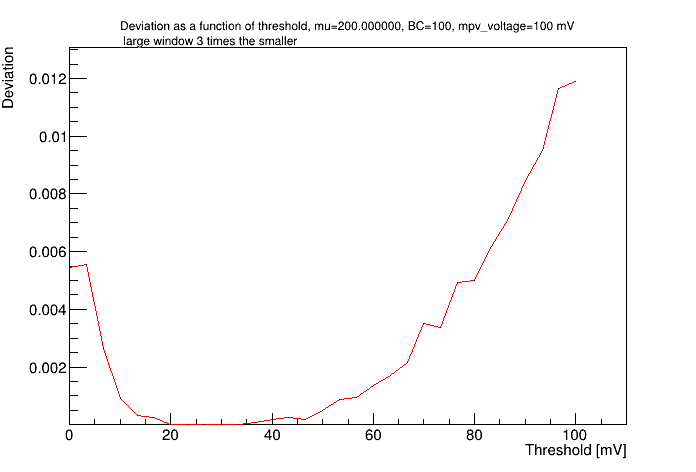

In [55]:
min_threshold = 0 #mV
max_threshold = 100 #mV
threshold_array = np.linspace(min_threshold,max_threshold,31)
total_deviation= np.zeros(len(threshold_array))
iteration = 0
start_time = time.time()

for threshold in threshold_array:
    
    true_signal, estimated_signal = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage)
    
    """Get the total deviation from the total simulated signals vs the expected signals.
        Returns both the total deviation as a positive number"""
    true_signal_sum = true_signal.sum()
    if true_signal_sum == 0:
        deviation = 0
    deviation = abs( estimated_signal.sum() / true_signal_sum -1)
    total_deviation[iteration] = deviation
    print("Deviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
    iteration = iteration+1

c1 = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%f, BC=%d, mpv_voltage=%d mV}{\n large window 3 times the smaller}"  %(mu, bunch_crossings, peak_mpv_voltage))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw(); 
c1.Draw()
c1.Modified()
c1.Update();
print("CPU time: %s seconds" % (time.time() - start_time))

### Finer search for the best threshold: exact value

Deviation for threshold 20.000000: 0.268243
Deviation for threshold 20.833333: 0.076790
Deviation for threshold 21.666667: 0.094346
Deviation for threshold 22.500000: 0.084437
Deviation for threshold 23.333333: 0.050798
Deviation for threshold 24.166667: 0.036079
Deviation for threshold 25.000000: 0.004201
Deviation for threshold 25.833333: 0.010481
Deviation for threshold 26.666667: 0.008064
Deviation for threshold 27.500000: 0.004292
Deviation for threshold 28.333333: 0.002701
Deviation for threshold 29.166667: 0.001493
Deviation for threshold 30.000000: 0.000570
Deviation for threshold 30.833333: 0.000752
Deviation for threshold 31.666667: 0.000936
Deviation for threshold 32.500000: 0.000719
Deviation for threshold 33.333333: 0.001112
Deviation for threshold 34.166667: 0.001035
Deviation for threshold 35.000000: 0.000556
Deviation for threshold 35.833333: 0.001612
Deviation for threshold 36.666667: 0.000904
Deviation for threshold 37.500000: 0.001653
Deviation for threshold 38.33333

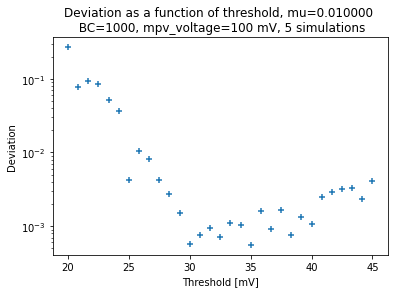

In [8]:
min_threshold = 25#mV
max_threshold = 45#mV
threshold_array = np.linspace(min_threshold,max_threshold,1)
total_deviation= np.zeros(len(threshold_array))
nr_of_simulations = 5
iteration = 0
start_time = time.time()

for threshold in threshold_array:   
    deviation_avg = np.zeros(nr_of_simulations)
    
    for i in range (nr_of_simulations):
        true_signal, estimated_signal = simulation(nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage)

        """Get the total deviation from the total simulated signals vs the expected signals.
            Returns both the total deviation as a positive number"""
        true_signal_sum = true_signal.sum()
        if true_signal_sum == 0:
            deviation = 0
        deviation = abs( estimated_signal.sum() / true_signal_sum -1)
        deviation_avg[i] = deviation
    
    deviation_avg = deviation_avg.sum()/nr_of_simulations
    total_deviation[iteration] = deviation_avg
    print("Deviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
    iteration = iteration+1    

plt.scatter(threshold_array, total_deviation, marker = "+")
plt.yscale("log")
plt.xlabel("Threshold [mV]")
plt.ylabel("Deviation")
plt.title ('Deviation as a function of threshold, mu=%f \n BC=%d, mpv_voltage=%d mV, %d simulations' %(mu, bunch_crossings, peak_mpv_voltage, nr_of_simulations))

best_threshold_index = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
print ("indexes:")
print(best_threshold_index)
if len(best_threshold_index)==1:
    print("best threshold: %f" %(threshold_array[best_threshold_index]))
print("CPU time: %s seconds" % (time.time() - start_time))

### Study which threshold is best: with SNR or the signal deviation from true values? 


In [ ]:
"""Ratio between real signal and real noise? Or between estimated signal and noise?"""



snr = 20 in the beginning
snr = 5 later 

large time window multiple of 3.125

todo later: check non-linear approximation of nr of particles vs mu 

